# ASR Assignment 2021-22

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2021-22/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


### Import Library

In [1]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import numpy as np
import time

### Generate State Table, Phone Table, Word Table from the Lexicon

In [2]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex




def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))

    return word_table, phone_table, state_table




lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

### Baseline wfst (my lab1 solution)

In [3]:
class BaselineWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM

        Returns:
            the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.self_loop_prob = self_loop_prob
        self.f = self.generate_wfst()
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state()
        f.set_start(start_state)

        for word, phones in self.lex.items():
            current_state = f.add_state()
            f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
            for idx,phone in enumerate(phones):
                if idx == len(phones)-1:
                    olabel = word_table.find(word)
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                else:
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
            # note: new current_state is now set to the final state of the previous phone WFST
            f.set_final(current_state)
            f.add_arc(current_state, fst.Arc(0, 0, 0, start_state))
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    

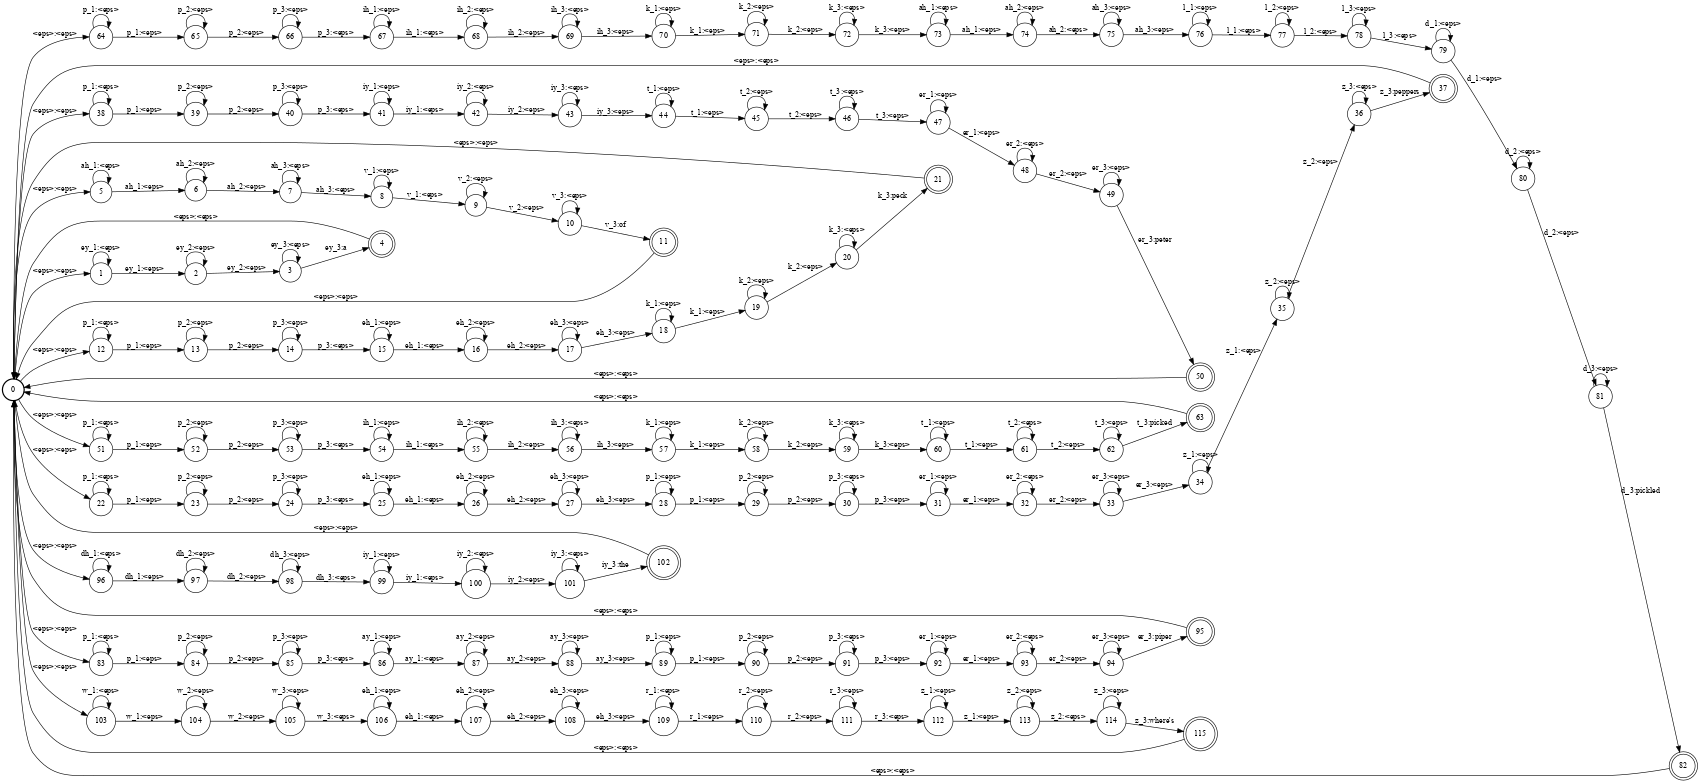

In [4]:
BaselineWfst().plot()

### Baseline Viterbi Decoder (lab3_4 solution)

In [5]:
import observation_model
import math

class BaselineViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        self.forward_cnt = 0
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        self.forward_cnt += 1
        
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)


In [11]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


    
class ASR:
    
    def __init__(self, wfst, decoder, audio_file_name, sample_num=5, self_loop_prob=None):
        """
        """
        self.self_loop_prob = self_loop_prob
        self.wfst = wfst(self_loop_prob=self.self_loop_prob).f
        self.decoder = decoder
        self.audio_file_name = audio_file_name
        self.sample_num = sample_num
        
        self.run()
    
    
    def run(self):
        """
        """
        
        
        records = []
        
        # run for each .wav file
        for idx,wav_file in enumerate(glob.glob(self.audio_file_name)):    # replace path if using your own
                                                                           # audio files
            if idx >= self.sample_num:
                 # average measuerments
                print("====================Result from {} samples==================".format(idx))
                self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy, self.decode_time, self.backtrace_time, self.forward_cnt = np.average(records, axis=0)
                self.print_all()
                break
            # create decoder
            decoder = self.decoder(self.wfst, wav_file)

            # measure decoding time
            start_time = time.time()
            decoder.decode()
            decode_time = time.time() - start_time
            
            # measure backtracing time
            start_time = time.time()
            (state_path, words) = decoder.backtrace()
            backtrace_time = time.time() - start_time
            
            # measure forward function counts in the decoding process
            forward_cnt = decoder.forward_cnt

            
            # measure WER accuracy
            transcription = read_transcription(wav_file)
            (sub_cnt, del_cnt, ins_cnt) = wer.compute_alignment_errors(transcription, words)
            word_cnt = len(transcription.split())
            accuracy = sum([sub_cnt, del_cnt, ins_cnt])/word_cnt
            
            
            # print results for each .wav file
            print(wav_file)
            print('Transcription: ' + transcription)
            print('Prediction: ' + words)
            print('Substiution: {}, Deletion: {}, Insertion: {}, Number of words: {}, Accuracy: {:.3f}'
                  .format(sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy))
            print()
            
            
            # save the measurements
            records.append([sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy, decode_time, backtrace_time, forward_cnt])
        
        # average measuerments
        self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy, self.decode_time, self.backtrace_time, self.forward_cnt = np.average(records, axis=0)
        
        
        
        
    def print_accuracy(self):
        """
        """
        print('-- Accuracy Info  *All Average Values* -------------------------------------------------------------')
        print('| Substiution: {:.3f}, Deletion: {:.3f}, Insertion: {:.3f}, Number of words: {:.3f}, Accuracy: {:.3f} |'
              .format(self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy))
        print('----------------------------------------------------------------------------------------------------')
        
        
    def print_speed(self):
        """
        """
        
        print('-- Speed Info  *All Average Values* ----------------------------------------------------------------')
        print('| Decoding time: {:.3f}s, Backtracing time: {:.3f}s, Number of forward computations: {:.3f}        |'
              .format(self.decode_time, self.backtrace_time, self.forward_cnt))
        print('----------------------------------------------------------------------------------------------------')
    
    def print_memory(self):
        """
        """
        
        num_arcs = 0
        for state in self.wfst.states():
            num_arcs += self.wfst.num_arcs(state)
            
        print('-- Memory Info -------------------------------------------------------------------------------------')
        print('| Number of states: {}, Number of arcs: {}                                                       |'
              .format(self.wfst.num_states(), num_arcs))
        print('----------------------------------------------------------------------------------------------------')

        
    def print_all(self):
        """
        """
        
        self.print_accuracy()
        self.print_speed()
        self.print_memory()

## Task 1 -Baseline-

In [ ]:
file_path = '/group/teaching/asr/labs/recordings/*.wav'
asr = ASR(BaselineWfst, BaselineViterbiDecoder, file_path, sample_num=10, self_loop_prob=None)
asr.print_all()

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 8, Accuracy: 1.500



## Task 2

### 1. Self-loop probability

In [ ]:
for i in range(11):
    prob = i * 0.1
    asr = ASR(BaselineWfst, BaselineViterbiDecoder, '/group/teaching/asr/labs/recordings/*.wav', sample_num=50, self_loop_prob=prob)
    asr.print_all()